# Dataset Information

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.


Variable | Description
----------|--------------
Item_Identifier | Unique product ID
Item_Weight | Weight of product
Item_Fat_Content | Whether the product is low fat or not
Item_Visibility | The % of total display area of all products in a    store allocated to the particular product
Item_Type | The category to which the product belongs
Item_MRP | Maximum Retail Price (list price) of the product
Outlet_Identifier | Unique store ID
Outlet_Establishment_Year | The year in which store was established
Outlet_Size | The size of the store in terms of ground area covered
Outlet_Location_Type | The type of city in which the store is located
Outlet_Type | Whether the outlet is just a grocery store or some sort of supermarket
Item_Outlet_Sales | Sales of the product in the particulat store. This is the outcome variable to be predicted.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
df=pd.read_csv('Train.csv')


In [3]:
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [4]:
df.shape

(8523, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Handling Missing Values

### Mean --> average

In [7]:
df['Item_Weight'].mean()

12.857645184136183

In [8]:
df['Item_Weight'].fillna(df['Item_Weight'].mean(),inplace=True)

In [9]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Mode --> more repeated value

In [10]:
df['Outlet_Size'].mode()

0    Medium
dtype: object

In [11]:
mode_of_Outlet_size = df.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=lambda x : x.mode()[0])

In [12]:
mode_of_Outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [13]:
miss_values = df['Outlet_Size'].isnull()

In [14]:
df.loc[miss_values, 'Outlet_Size'] = df.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [15]:
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### DATA ANALYSIS


In [16]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### NUMERICAL FEATURES

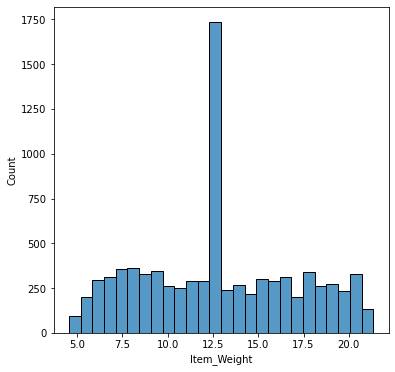

In [17]:
plt.figure(figsize=(6,6))
sns.histplot(df['Item_Weight'])
plt.show()

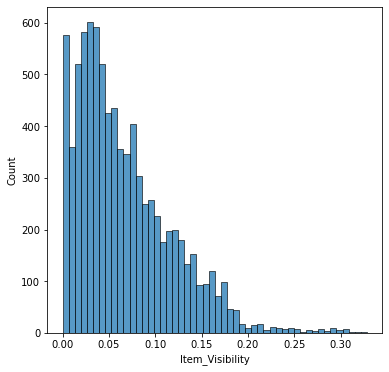

In [18]:
plt.figure(figsize=(6,6))
sns.histplot(df['Item_Visibility'])
plt.show()

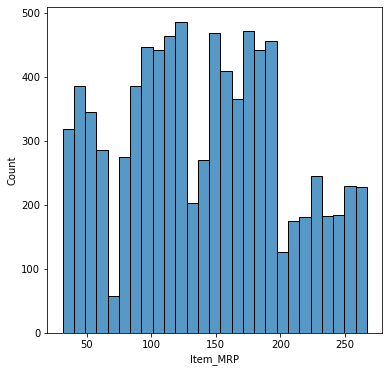

In [19]:
plt.figure(figsize=(6,6))
sns.histplot(df['Item_MRP'])
plt.show()

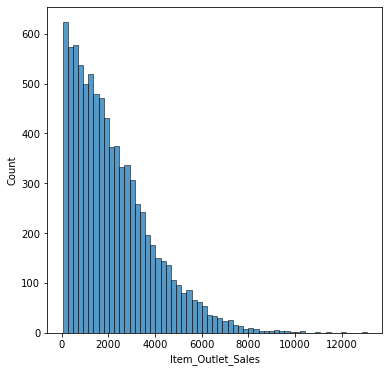

In [20]:
plt.figure(figsize=(6,6))
sns.histplot(df['Item_Outlet_Sales'])
plt.show()

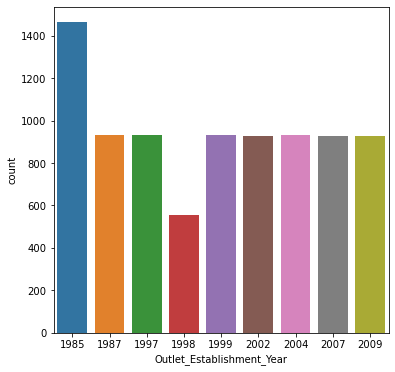

In [21]:
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=df)
plt.show()

### Categorical Features

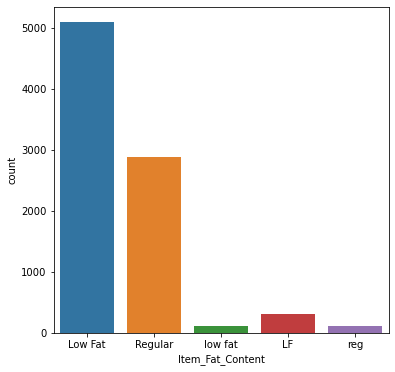

In [22]:
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=df)
plt.show()

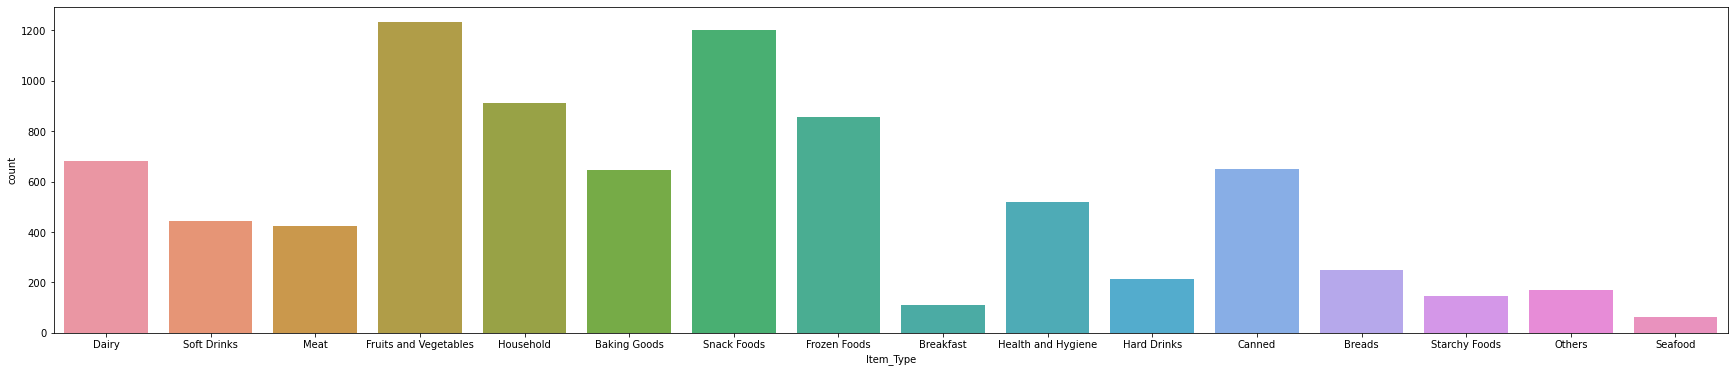

In [23]:
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=df)
plt.show()

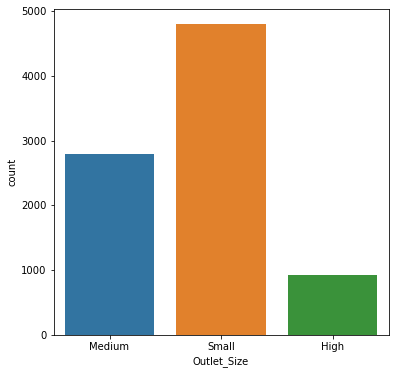

In [24]:
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=df)
plt.show()

### Data Pre-Processing

In [25]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [26]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [27]:
df.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [28]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

### Label Encoding

In [29]:
encoder = LabelEncoder()

In [30]:
df['Item_Identifier'] = encoder.fit_transform(df['Item_Identifier'])

df['Item_Fat_Content'] = encoder.fit_transform(df['Item_Fat_Content'])

df['Item_Type'] = encoder.fit_transform(df['Item_Type'])

df['Outlet_Identifier'] = encoder.fit_transform(df['Outlet_Identifier'])

df['Outlet_Size'] = encoder.fit_transform(df['Outlet_Size'])

df['Outlet_Location_Type'] = encoder.fit_transform(df['Outlet_Location_Type'])

df['Outlet_Type'] = encoder.fit_transform(df['Outlet_Type'])

In [31]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


### Splitting features and Target 

In [32]:
X = df.drop(columns='Item_Outlet_Sales', axis=1)
Y = df['Item_Outlet_Sales']

In [33]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [34]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


### Splitting the data into Training data & Testing Data

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

In [36]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


### Machine Learning Model Training 

### XGBoost Regressor

In [37]:
regressor = XGBRegressor()

In [38]:
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [39]:
training_data_prediction = regressor.predict(X_train)

In [40]:
r2_train = metrics.r2_score(Y_train, training_data_prediction)

In [41]:
print('R Squared value = ', r2_train)

R Squared value =  0.864711902578474


In [42]:
test_data_prediction = regressor.predict(X_test)


In [43]:
r2_test = metrics.r2_score(Y_test, test_data_prediction)

In [44]:
print('R Squared value = ', r2_test)

R Squared value =  0.5310498042616734
